In [1]:
import os
import re

from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from time import sleep

from bot.core.exchange.http_api import ExchangeManager, BybitRestAPI
from bot.utils.files import load_tokens_from_file
from bot.utils.coinmarketcap import get_top_tokens
from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name

db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

import pandas as pd
# pd.options.display.float_format = '{:.2f}'.format

import polars as pl
import polars_ols as pls

import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

In [2]:
def sort_pairs(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([
        pl.when(pl.col("coin1") <= pl.col("coin2")).then(pl.col("coin1")).otherwise(pl.col("coin2")).alias("pair_min"),
        pl.when(pl.col("coin1") <= pl.col("coin2")).then(pl.col("coin2")).otherwise(pl.col("coin1")).alias("pair_max"),
    ]).drop('coin1', 'coin2').rename({'pair_min': 'coin1', 'pair_max': 'coin2'}).select('coin1', 'coin2', pl.exclude('coin1', 'coin2'))

In [3]:
# get_top_tokens(limit=1000, output_file='./bot/config/top_1000_tokens.txt')

#### Скачиваем данные с Bybit

In [4]:
async def get_data(symbol, interval, n_iters):
    df = await exc_manager.get_candles(symbol=symbol, interval=interval, n_iters=n_iters)
    df = df['bybit_linear'].sort_index()
    df['Returns'] = df['Close'].pct_change()
    df['Log_price'] = np.log(df['Close'] + 1)
    df['Log_returns'] = np.log(df['Returns'] + 1)
    return df.dropna()

In [5]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))

In [6]:
res = await get_data(symbol='ADA_USDT', interval='1h', n_iters=1)
res.shape

(999, 11)

In [55]:
top_1000_tokens = load_tokens_from_file("./data/top_1000_tokens.txt")
tokens_to_del = ['USDT', 'USDC', 'LEO', 'USDe']
prices = await exc_manager.get_prices()
prices = prices['bybit_linear']

token_list = [x + '_USDT' for x in top_1000_tokens if x not in tokens_to_del]
token_list = [col for col in token_list if col in prices.keys()]
len(token_list)

503

In [56]:
with open('./bot/config/tokens.txt', 'r') as file:
    current_tokens = [line.strip() for line in file.readlines()]
len(current_tokens)

80

In [57]:
all_ = db_manager.get_orderbooks()
all_tokens = all_['token'].unique().to_list()

In [58]:
# Отбираем только те токены, которые есть в БД с ордербуками
token_list = []

for token in sorted(all_tokens):
    first_date = db_manager.get_oldest_date_in_orderbook(token)
    
    if first_date < datetime(2025, 11, 12, 0, tzinfo=ZoneInfo("Europe/Moscow")):
        token_list.append(token)
len(token_list)

61

In [59]:
# Настройки параметров
interval = '1d'
n_iters = 1
start_date = datetime(2025, 5, 10, tzinfo=ZoneInfo("Europe/Moscow"))
end_date = datetime(2025, 11, 19, tzinfo=ZoneInfo("Europe/Moscow"))
min_volume = 1_000_000
days_ago = 30 # За сколько последних дней смотреть волатильность
max_volatility = 52
max_price = 30

In [60]:
main_df = pd.DataFrame()

token_dict = {'PEPE_USDT': '1000PEPE_USDT', 'SHIB_USDT': 'SHIB1000_USDT', 'FLOKI_USDT': '1000FLOKI_USDT',
             'BONK_USDT': '1000BONK_USDT', 'BTT_USDT': '1000BTT_USDT', 'XEC_USDT': '1000XEC_USDT',
             'LUNC_USDT': '1000LUNC_USDT', 'SATS_USDT': '10000SATS_USDT', 'TURBO_USDT': '1000TURBO_USDT',
             'CAT_USDT': '1000CAT_USDT'}
bad_tokens = []
good_tokens = []

for token in tqdm(token_list):
    sleep(0.5)
    df = await get_data(symbol=token, interval=interval, n_iters=n_iters)
    df = df.reset_index()

    if df.empty:
        continue
    
    first_date = df['Date'].head(1).item().floor('D')
    last_date = df['Date'].tail(1).item().floor('D')
    
    if first_date > pd.Timestamp('2025-06-10', tz='Europe/Moscow'):
        continue
    if last_date < pd.Timestamp('2025-11-10', tz='Europe/Moscow'):
        continue

    vol_mean = df[-11: -1]['Turnover'].mean()
    vol24 = df.iloc[-2]['Turnover']
    if vol24 < min_volume or vol_mean < min_volume:
        if token in current_tokens:
            print(f'{token} недостаточно торгового объёма (10d_avg: {int(vol_mean):_} / last_24h: {int(vol24):_})')
            bad_tokens.append(token)
        continue
    
    df = df[(df['Date'] > start_date) & (df['Date'] < end_date)]
    df = df.set_index('Date')
    daily_df = df[-days_ago:]
    daily_df['Max_range'] = daily_df['High'] - daily_df['Low']
    daily_df['Max_range_perc'] = (daily_df['High'] - daily_df['Low']) / daily_df['Low'] * 100

    if daily_df['Max_range_perc'].max() > max_volatility:
        if token in current_tokens:
            print(f'{token} высокая волатильность: {daily_df['Max_range_perc'].max():.1f}%')
            bad_tokens.append(token)
        continue

    if daily_df['Close'][-1] > max_price:
        continue

    main_df[f'{token[:-5]}_price'] = df['Close']
    main_df[f'{token[:-5]}_log_returns'] = df['Log_returns']
    main_df[f'{token[:-5]}_log_price'] = df['Log_price']
    good_tokens.append(token)

  0%|          | 0/61 [00:00<?, ?it/s]

In [61]:
main_df.shape

(193, 183)

In [62]:
len(current_tokens), len(bad_tokens), len(good_tokens)

(80, 0, 61)

In [ ]:
[current_tokens.remove(token) for token in bad_tokens]
len(current_tokens)

In [63]:
len(good_tokens), len(set(good_tokens))

(61, 61)

#### Distance approach

In [19]:
from bot.utils.data import make_price_df_from_orderbooks_bulk, normalize
import itertools
import math

In [67]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))
coin_information = exc_manager.get_instrument_data()

In [68]:
# Создадим список из датафреймов для удобства пакетной обработки, а также получим кол-во знаков после запятой для округления
max_days = 180 # За сколько дней считать расстояние
tokens = [x[:-5] for x in sorted(good_tokens)]
dfs = []
token_std = {}
token_dist = {}

for token in tokens:
    try:
        df_token = main_df[[f'{token}_price']].rename(columns={f'{token}_price': 'price'})
        df_token['token'] = token
        df_token = pl.from_pandas(df_token, include_index=True).rename({'Date': 'time'}).tail(max_days)
    except KeyError:
        print(token)
        continue
    
    try:
        dp = coin_information['bybit_linear'][token + '_USDT']['qty_step']
    except IndexError:
        dp = 0

    token_std[token] = df_token['price'].std()
    token_dist[token] = df_token['price'].max() - df_token['price'].min()
    dfs.append(df_token)

In [69]:
price_df = make_price_df_from_orderbooks_bulk(dfs=dfs, tokens=tokens, trunc='5m')
curr_prices = price_df.drop('time').tail(1).transpose(include_header=True, header_name='coin', column_names=['price'])
price_df.tail(1)

time,1INCH,ADA,ALGO,APT,ARB,ARKM,ATOM,BLUR,CELO,CHZ,CRV,DOGE,DOT,DRIFT,DYDX,EGLD,ENA,ETHFI,FARTCOIN,FLOW,GALA,GLM,GMT,GRT,HBAR,IMX,INJ,IOTA,JASMY,JUP,KAS,LDO,MANA,MANTA,MORPHO,MOVE,NEAR,NXPC,ONDO,OP,ORDI,PNUT,POL,RENDER,ROSE,RUNE,SAND,SEI,STRK,STX,SUI,SUSHI,S,THETA,TIA,TON,TRX,VET,WIF,XLM,XRP
"datetime[ns, Europe/Moscow]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-11-18 03:00:00 MSK,0.1888,0.475,0.1567,2.91,0.2371,0.2838,2.756,0.04119,0.187,0.03086,0.4356,0.16163,2.7535,0.2733,0.2873,8.39,0.2775,0.92,0.2572,0.2626,0.008686,0.22923,0.02113,0.05609,0.1505,0.3804,6.598,0.1277,0.008177,0.2668,0.04327,0.7338,0.1977,0.10978,1.8836,0.05489,2.274,0.445,0.5459,0.3803,4.678,0.098,0.1492,2.062,0.01855,0.732,0.1777,0.1507,0.2048,0.3461,1.6679,0.4716,0.1237,0.4083,0.7903,1.7936,0.29004,0.01486,0.4166,0.25577,2.2163


In [70]:
price_df.shape, price_df.drop_nans().shape

((180, 62), (180, 62))

In [71]:
normed_df = normalize(df=price_df, method='minimax', shift_to_zero=False)

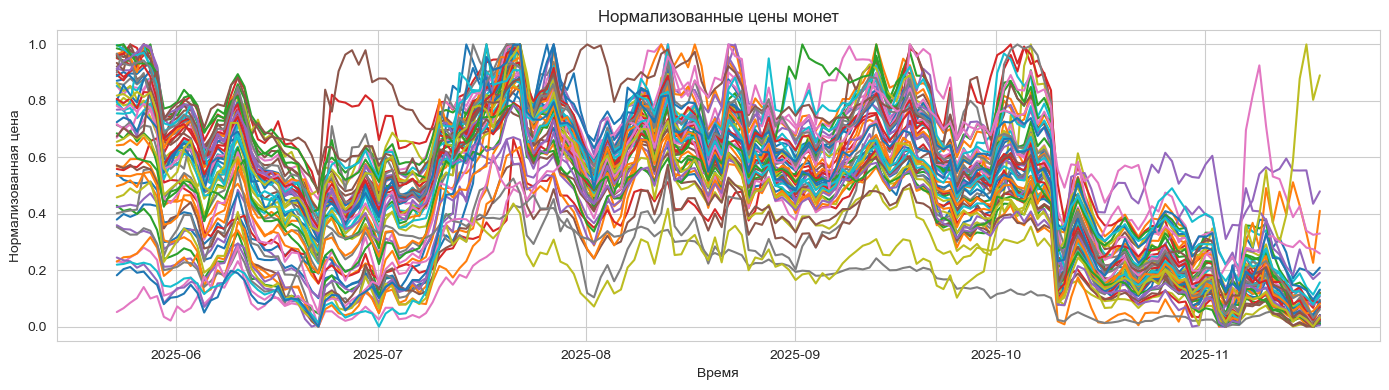

In [72]:
# Нарисуем график с нормализованными ценами
price_cols = [c for c in normed_df.columns if c != 'time']

plt.figure(figsize=(14, 4))
for col in price_cols:
    plt.plot(normed_df['time'].to_list(), normed_df[col].to_list(), label=col)

plt.xlabel("Время")
plt.ylabel("Нормализованная цена")
plt.title("Нормализованные цены монет")
plt.grid(True)
plt.tight_layout()

In [73]:
# Посчитаем евклидово расстояние между парами криптовалют
results = []

# Перебираем все уникальные пары колонок
for col1, col2 in itertools.combinations(price_cols, 2):
    diff_sq = (normed_df[col1] - normed_df[col2]) ** 2
    distance = math.sqrt(diff_sq.sum())
    std = np.std((normed_df[col1] - normed_df[col2]).to_numpy())
    results.append((col1, col2, distance, std))

In [85]:
std_df = pl.DataFrame({"token": list(token_std.keys()), "std_value": list(token_std.values())})
max_dist_df = pl.DataFrame({"token": list(token_dist.keys()), "max_dist": list(token_dist.values())})

In [93]:
dist_df = pl.DataFrame(results, schema=["coin1", "coin2", "dist", "std"], orient="row").sort('dist')
dist_df = dist_df.join(curr_prices, left_on='coin1', right_on='coin').rename({'price': 'price1'})
dist_df = dist_df.join(curr_prices, left_on='coin2', right_on='coin').rename({'price': 'price2'})
dist_df = dist_df.filter(
    (pl.col('price1') / pl.col('price2') < 5) & (pl.col('price1') / pl.col('price2') > 0.2)
)

In [95]:
dist_df = dist_df.join(std_df, left_on="coin1", right_on="token").rename({"std_value": "std_1"})
dist_df = dist_df.join(std_df, left_on="coin2", right_on="token").rename({"std_value": "std_2"})

dist_df = dist_df.join(max_dist_df, left_on="coin1", right_on="token").rename({"max_dist": "dist_1"})
dist_df = dist_df.join(max_dist_df, left_on="coin2", right_on="token").rename({"max_dist": "dist_2"})

In [96]:
dist_df

coin1,coin2,dist,std,price1,price2,std_1,std_2,dist_1,dist_2
str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""GALA""","""VET""",0.502005,0.030071,0.008686,0.01486,0.002941,0.003508,0.011878,0.01441
"""SAND""","""THETA""",0.695081,0.045316,0.1777,0.4083,0.040333,0.138308,0.1733,0.5871
"""PNUT""","""WIF""",0.728474,0.051318,0.098,0.4166,0.057918,0.200172,0.2472,0.8849
"""RUNE""","""TIA""",0.733531,0.054671,0.732,0.7903,0.297094,0.422802,1.282,1.864
"""BLUR""","""GRT""",0.757171,0.050341,0.04119,0.05609,0.01689,0.014891,0.07152,0.06105
…,…,…,…,…,…,…,…,…,…
"""STRK""","""THETA""",5.436586,0.270546,0.2048,0.4083,0.018702,0.138308,0.1151,0.5871
"""MOVE""","""STRK""",5.565623,0.310026,0.05489,0.2048,0.035155,0.018702,0.13605,0.1151
"""ENA""","""NXPC""",5.656716,0.393585,0.2775,0.445,0.17128,0.378161,0.5715,1.846


In [31]:
# Добавить фичи: скорость возврата к среднему

#### Cointegration approach

In [98]:
ret_cols = [col for col in main_df.columns if '_log_price' in col]
corr_matrix = main_df[ret_cols].corr()

In [99]:
corr_matrix

,1INCH_log_price,ADA_log_price,ALGO_log_price,APT_log_price,ARB_log_price,ARKM_log_price,ATOM_log_price,BLUR_log_price,CELO_log_price,CHZ_log_price,...,SUSHI_log_price,S_log_price,THETA_log_price,TIA_log_price,TON_log_price,TRX_log_price,VET_log_price,WIF_log_price,XLM_log_price,XRP_log_price
1INCH_log_price,1.000000,0.775367,0.911849,0.572293,0.774195,0.631658,0.705622,0.604716,0.618278,0.767419,...,0.836889,0.429385,0.713672,0.507092,0.642777,0.538792,0.673749,0.659195,0.855558,0.832057
ADA_log_price,0.775367,1.000000,0.855721,0.579395,0.953636,0.733081,0.733388,0.604302,0.665679,0.810435,...,0.850455,0.447994,0.762106,0.525614,0.683250,0.692255,0.713995,0.599478,0.799429,0.811611
ALGO_log_price,0.911849,0.855721,1.000000,0.593915,0.851453,0.671143,0.756783,0.665674,0.710121,0.789822,...,0.914086,0.494702,0.790771,0.564993,0.715179,0.568857,0.741935,0.703243,0.880187,0.867258
APT_log_price,0.572293,0.579395,0.593915,1.000000,0.594911,0.889573,0.923007,0.898659,0.850671,0.864500,...,0.760174,0.902704,0.904603,0.896177,0.841516,-0.020279,0.907724,0.906399,0.274467,0.279996
ARB_log_price,0.774195,0.953636,0.851453,0.594911,1.000000,0.720197,0.776440,0.596450,0.625756,0.782629,...,0.872847,0.474649,0.783791,0.536777,0.736856,0.681787,0.724657,0.638000,0.749416,0.781193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRX_log_price,0.538792,0.692255,0.568857,-0.020279,0.681787,0.096113,0.174205,-0.061395,0.065017,0.248860,...,0.444152,-0.247159,0.185967,-0.173589,0.218862,1.000000,0.079167,0.023666,0.804267,0.824162
VET_log_price,0.673749,0.713995,0.741935,0.907724,0.724657,0.955508,0.966515,0.968771,0.896275,0.942302,...,0.875400,0.927963,0.976738,0.955861,0.874221,0.079167,1.000000,0.926249,0.396484,0.406157
WIF_log_price,0.659195,0.599478,0.703243,0.906399,0.638000,0.891704,0.951474,0.936392,0.811813,0.843756,...,0.857386,0.879101,0.952349,0.909858,0.901103,0.023666,0.926249,1.000000,0.370829,0.388279
XLM_log_price,0.855558,0.799429,0.880187,0.274467,0.749416,0.363522,0.444653,0.310390,0.418464,0.540650,...,0.709308,0.078585,0.484625,0.168107,0.439115,0.804267,0.396484,0.370829,1.000000,0.970954


In [100]:
# token = 'SUSHI'
# token_df = corr_matrix[f'{token}_log_price']
# token_df.shape

In [101]:
# token_df[abs(token_df) < 0.1]

In [102]:
# token_df[abs(token_df) > 0.75]

In [103]:
stacked = corr_matrix.stack().reset_index()
stacked.columns = ['stock1', 'stock2', 'correlation']
# filtered_pairs = stacked[(stacked['correlation'] > 0.6) & (stacked['stock1'] < stacked['stock2'])].reset_index(drop=True)

In [133]:
results = []
processed = []
n_rows = 180 # Сколько последних записей учитывать
total = len(list(itertools.combinations(price_cols, 2)))

# for _, row in tqdm(stacked.iterrows(), total=stacked.shape[0]):
for col1, col2 in tqdm(itertools.combinations(price_cols, 2), total=total):
    stock1 = col1 + '_log_price'
    stock2 = col2 + '_log_price'
    
        
    corr_value = pl.DataFrame(stacked).filter(
            (pl.col('stock1') == stock1) & (pl.col('stock2') == stock2)
        ).select('correlation').item()
    

    data = main_df[[stock1, stock2]].dropna()
    data = data[-n_rows:]

    if data.empty:
        print(f"Пара {stock1}-{stock2} пропущена, т.к. нет данных после очистки")
        continue

    adf_stat_1, p_value_1, _ = coint(data[stock1], data[stock2], trend='c')
    adf_stat_2, p_value_2, _ = coint(data[stock2], data[stock1], trend='c')

    beta_1 = np.cov(data[stock1].values, data[stock2].values)[0, 1] / np.var(data[stock1].values)
    beta_2 = np.cov(data[stock2].values, data[stock1].values)[0, 1] / np.var(data[stock2].values)

    results.append({
        'coin1': col1,
        'coin2': col2,
        'corr': corr_value,
        'adf_1': adf_stat_1,
        'pv_1': p_value_1,
        'adf_2': adf_stat_2,
        'pv_2': p_value_2,
        'beta_1': beta_1,
        'beta_2': beta_2
    })

    processed.append((stock1, stock2))

result_df = pd.DataFrame(results)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [134]:
coint_df = pl.DataFrame(result_df)
coint_df

coin1,coin2,corr,adf_1,pv_1,adf_2,pv_2,beta_1,beta_2
str,str,f64,f64,f64,f64,f64,f64,f64
"""1INCH""","""ADA""",0.775367,-2.555153,0.255301,-1.541819,0.74481,1.587724,0.38611
"""1INCH""","""ALGO""",0.911849,-3.24625,0.062528,-2.774467,0.173944,0.805547,1.055598
"""1INCH""","""ARB""",0.774195,-3.04622,0.099623,-1.622622,0.711248,1.360767,0.44643
"""1INCH""","""ARKM""",0.631658,-3.09697,0.088913,-2.413488,0.318494,1.332745,0.371673
"""1INCH""","""BLUR""",0.604716,-2.975277,0.1162,-1.047371,0.893488,0.309532,1.568411
…,…,…,…,…,…,…,…,…
"""TRX""","""WIF""",0.023666,-1.726798,0.66455,-1.088224,0.884797,0.727784,0.026229
"""TRX""","""XLM""",0.804267,-2.494058,0.281696,-2.253841,0.396797,1.988026,0.338349
"""TRX""","""XRP""",0.824162,-2.665577,0.212203,-2.619467,0.229061,4.170849,0.170476


In [37]:
# dist_df = sort_pairs(dist_df)
# coint_df = sort_pairs(coint_df)

In [136]:
pair_stats_df = dist_df.drop('price1', 'price2').join(coint_df, on=['coin1', 'coin2'], how='left')
pair_stats_df = pair_stats_df.filter(
    # (pl.col('p_value_1') < 0.1) & (pl.col('p_value_2') < 0.1) & 
    (pl.col('dist') > 0.8) & (pl.col('dist') < 2.8) & (abs(pl.col('beta_1') - pl.col('beta_2')) < 1.6)
).rename({'dist': 'spr_dist', 'std': 'spr_std'}).drop('adf_1', 'adf_2')

In [137]:
pair_stats_df

coin1,coin2,spr_dist,spr_std,std_1,std_2,dist_1,dist_2,corr,pv_1,pv_2,beta_1,beta_2
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""GRT""","""KAS""",0.810146,0.056196,0.014891,0.016346,0.06105,0.07195,0.976599,0.001143,0.001464,1.084126,0.885382
"""FLOW""","""THETA""",0.836711,0.062348,0.053483,0.138308,0.2144,0.5871,0.971219,0.287071,0.682952,2.028445,0.466785
"""FLOW""","""SAND""",0.84201,0.056873,0.053483,0.040333,0.2144,0.1733,0.976927,0.189748,0.174703,0.79013,1.217839
"""PNUT""","""STX""",0.850071,0.058142,0.057918,0.138671,0.2472,0.5662,0.973448,0.005207,0.009045,1.76904,0.54189
"""EGLD""","""RENDER""",0.850245,0.06265,2.525693,0.667813,10.094,2.919,0.978074,0.238697,0.187699,0.841394,1.13983
…,…,…,…,…,…,…,…,…,…,…,…,…
"""INJ""","""NEAR""",2.779139,0.202513,2.444753,0.298259,9.989,1.346,0.601366,0.971568,0.047048,0.243227,1.513273
"""FARTCOIN""","""NXPC""",2.780998,0.128607,0.356705,0.378161,1.4344,1.846,0.870476,0.642433,0.184235,0.894593,0.909725
"""1INCH""","""ARKM""",2.783042,0.17761,0.043827,0.098634,0.2072,0.4146,0.631658,0.088913,0.318494,1.332745,0.371673


In [138]:
# Проверка, есть ли такая пара в нашей выборке
token_1 = 'CELO'
token_2 = 'IOTA'
pair_stats_df.filter(
    ((pl.col('coin1') == token_1) & (pl.col('coin2') == token_2)) | 
    ((pl.col('coin2') == token_1) & (pl.col('coin1') == token_2))
)

coin1,coin2,spr_dist,spr_std,std_1,std_2,dist_1,dist_2,corr,pv_1,pv_2,beta_1,beta_2
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""CELO""","""IOTA""",1.524335,0.107946,0.046886,0.027106,0.239,0.1179,0.912268,0.034875,0.126047,0.567952,1.39879


In [46]:
pair_stats_df.write_parquet('./data/pair_selection/curr_pairs.parquet')

In [ ]:
# pair_stats_df = pl.read_parquet('./data/pair_selection/curr_pairs.parquet')

In [63]:
pair_stats_df.filter(
    ((pl.col('coin1') == 'CELO') & (pl.col('coin2') == 'POL')) | 
    ((pl.col('coin1') == 'SEI') & (pl.col('coin2') == 'DYDX'))   |
    ((pl.col('coin1') == 'IOTA') & (pl.col('coin2') == 'MANA'))   |
    ((pl.col('coin1') == 'FLOW') & (pl.col('coin2') == 'MANTA'))    
)

coin1,coin2,spr_dist,spr_std,std_1,std_2,dist_1,dist_2,corr,pv_1,pv_2,beta_1,beta_2
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""IOTA""","""MANA""",1.678996,0.112637,0.027142,0.037978,0.1179,0.1762,0.89722,0.356315,0.314913,1.229219,0.627842
"""CELO""","""POL""",2.280834,0.168797,0.046897,0.032058,0.239,0.1445,0.696334,0.119226,0.522829,0.466372,0.998055
"""SEI""","""DYDX""",2.411253,0.168423,0.060115,0.126161,0.2225,0.4693,0.720787,0.297405,0.453429,1.696004,0.385073


In [47]:
pairs = db_manager.get_table('pairs', df_type='polars')

In [48]:
token_list = []

for row in pair_stats_df.iter_rows(named=True):
    t1 = row["coin1"]
    t2 = row["coin2"]

    if (t1, t2) not in token_list and (t2, t1) not in token_list:
        token_list.append((t1, t2))
len(token_list)

261

In [49]:
for row in pairs.iter_rows(named=True):
    t1 = row['token_1'][:-5]
    t2 = row['token_2'][:-5]
    
    if (t1, t2) not in token_list and (t2, t1) not in token_list:
        token_list.append((t1, t2))
        print((t1, t2))

('CHZ', 'VET')
('IOTA', 'CELO')
('GMT', 'BLUR')


In [50]:
token_list

[('GRT', 'KAS'),
 ('SAND', 'FLOW'),
 ('STX', 'WIF'),
 ('MANTA', 'PNUT'),
 ('INJ', 'ORDI'),
 ('S', 'MANTA'),
 ('OP', 'DYDX'),
 ('S', 'PNUT'),
 ('ORDI', 'EGLD'),
 ('XLM', 'HBAR'),
 ('GRT', 'GMT'),
 ('ONDO', 'OP'),
 ('THETA', 'DYDX'),
 ('THETA', 'OP'),
 ('SUSHI', 'CRV'),
 ('FARTCOIN', 'RUNE'),
 ('THETA', 'ONDO'),
 ('SAND', 'MANA'),
 ('JUP', 'THETA'),
 ('ATOM', 'SUI'),
 ('SAND', 'JUP'),
 ('GALA', 'ROSE'),
 ('TIA', 'WIF'),
 ('S', 'STX'),
 ('DRIFT', 'IMX'),
 ('ETHFI', 'IMX'),
 ('ARKM', 'OP'),
 ('ALGO', '1INCH'),
 ('ATOM', 'RENDER'),
 ('STX', 'THETA'),
 ('WIF', 'FARTCOIN'),
 ('ATOM', 'DOT'),
 ('JUP', 'ONDO'),
 ('VET', 'ROSE'),
 ('SUI', 'RENDER'),
 ('GMT', 'KAS'),
 ('DOT', 'RENDER'),
 ('INJ', 'EGLD'),
 ('ATOM', 'TON'),
 ('THETA', 'ARKM'),
 ('WIF', 'RUNE'),
 ('JUP', 'ARKM'),
 ('SAND', 'PNUT'),
 ('ADA', 'ONDO'),
 ('ARKM', 'PNUT'),
 ('DOT', 'SUI'),
 ('THETA', 'WIF'),
 ('MANA', 'POL'),
 ('FLOW', 'ARKM'),
 ('ALGO', 'HBAR'),
 ('FLOW', 'JUP'),
 ('ATOM', 'APT'),
 ('MANTA', 'ARKM'),
 ('ALGO', 'XLM'),
 

In [51]:
with open('./data/token_pairs.txt', 'w') as file:
    for pair in token_list:
        file.write(f"{pair[0]} {pair[1]}\n")